In [1]:
import numpy as np
import matplotlib.pyplot as plt
from lotkavolterra_simulator import LVsimulator, LVobserver

## Theory

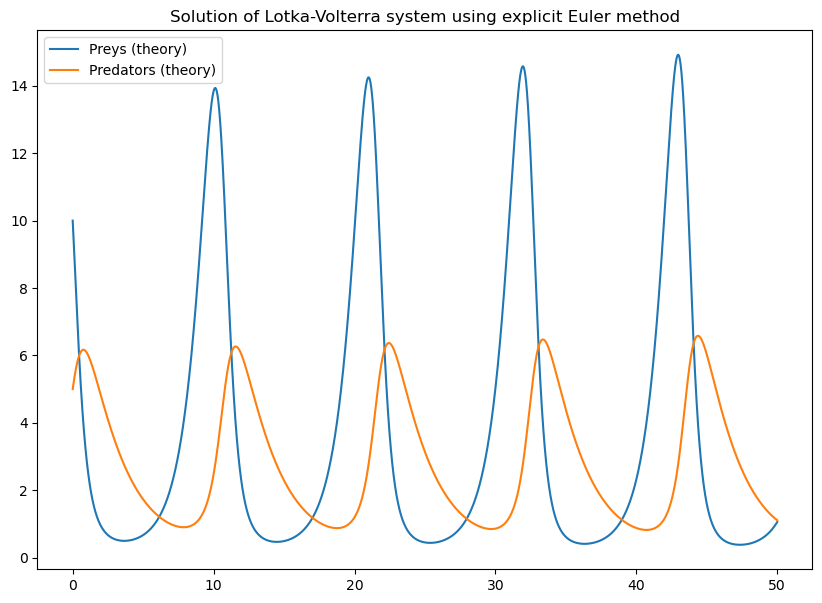

In [2]:
tmax=50
tres=100
t = np.linspace(0,tmax,tmax*tres+1)
t_s = np.arange(tmax)
Delta_t = 2.

# True values
alpha, beta, gamma, delta = 1.1, 0.4, 0.4, 0.1
X0, Y0 = 10, 5

# Define simulator instance
LVt = LVsimulator(X0, Y0, alpha, beta, gamma, delta)

# Solve the ODEs
Xtheory, Ytheory = LVt.EEuler(t)

# Plot the solution
plt.figure(figsize=(10,7))
plt.plot(t,Xtheory,label="Preys (theory)")
plt.plot(t,Ytheory,label="Predators (theory)")
plt.legend(loc="best")
plt.title("Solution of Lotka-Volterra system using explicit Euler method")
plt.show()

## Signal and observed data

In [3]:
# Simulate true data
threshold = 11
obsP=0.05
obsQ=0.01
obsR0=0.15
obsS=0.05
obsT=0.2
Xtrue=np.array([Xtheory[tres*n] for n in range(tmax)])
Ytrue=np.array([Ytheory[tres*n] for n in range(tmax)])

# Define a mask
masks=[np.array([4, 5, 6]), np.array([19, 20]), np.array([35, 36, 37])]
mask=np.array([0 if n in np.concatenate(masks) else 1 for n in range(tmax)])

def X_efficiency(t):
    return 1./2.*(1+np.cos(t/(1.7*Delta_t)-1/3*np.pi))
def Y_efficiency(t):
    return 1.
Xefficiency0 = X_efficiency(t_s)
Yefficiency0 = Y_efficiency(t_s)

# Define observer instance and simulate observed data
LVo = LVobserver(Xtrue, Ytrue, X0, Y0)
LVo.observe(Xefficiency=Xefficiency0, Yefficiency=Yefficiency0, threshold=threshold, mask=mask, obsP=obsP, obsQ=obsQ, obsR=obsR0, obsS=obsS, obsT=obsT)
Xobs, Xdata, Yobs, Ydata = LVo.Xobs, LVo.Xdata, LVo.Yobs, LVo.Ydata

In [4]:
# Check the model for the signal
Xtsignal, Ytsignal = LVo.make_signal(Xefficiency=Xefficiency0, Yefficiency=Yefficiency0, obsP=obsP, obsQ=obsQ)

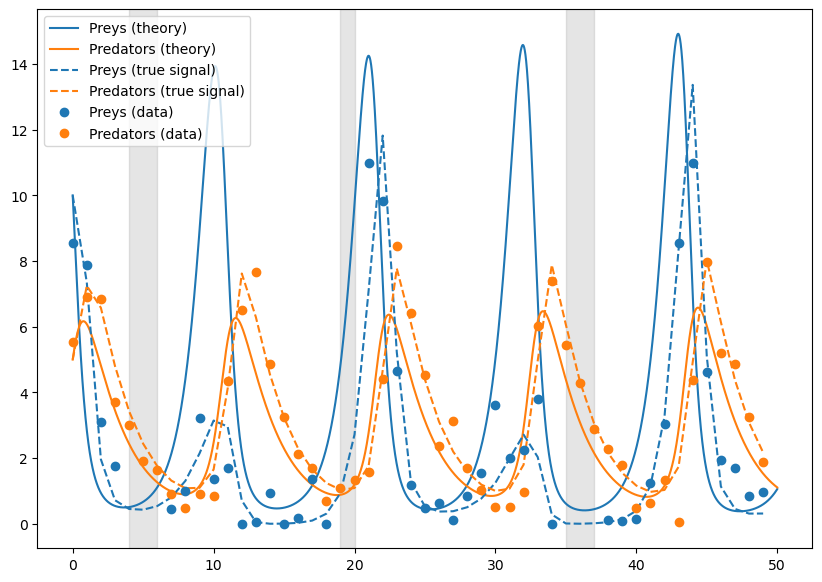

In [5]:
# Plot the theory, signal, and data
plt.figure(figsize=(10,7))
plt.plot(t,Xtheory,label="Preys (theory)")
plt.plot(t,Ytheory,label="Predators (theory)")
plt.plot(np.arange(tmax),Xtsignal,ls="--",color="C0",label="Preys (true signal)")
plt.plot(np.arange(tmax),Ytsignal,ls="--",color="C1",label="Predators (true signal)")
plt.plot(Xobs,Xdata,marker="o",ls="",color="C0",label="Preys (data)")
plt.plot(Yobs,Ydata,marker="o",ls="",color="C1",label="Predators (data)")
ymin, ymax = plt.ylim()
for i in range(len(masks)):
    plt.fill_between(masks[i],np.ones_like(masks[i])*ymin,np.ones_like(masks[i])*ymax,color="C7",alpha=0.2)
plt.ylim(ymin,ymax)
plt.legend(loc="best")
plt.show()

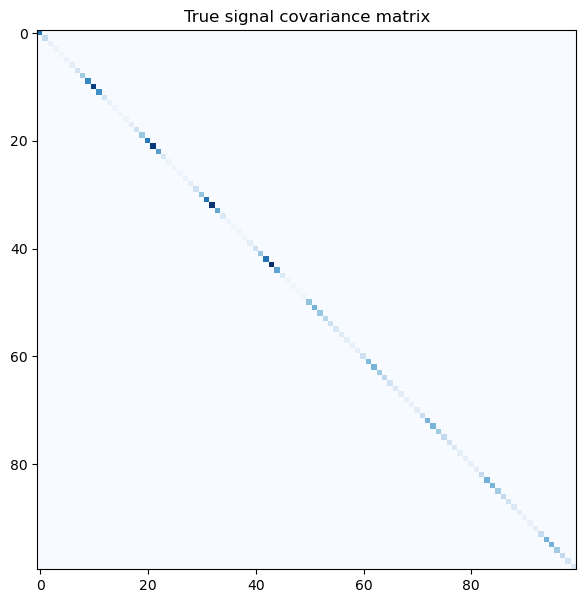

In [6]:
# Check model for the covariance matrix
N=LVo.Dnoise_cov(obsR=0.05, obsS=0.005, obsT=5)
plt.figure(figsize=(7,7))
plt.imshow(np.log(1+N),cmap="Blues")
plt.title("True signal covariance matrix")
plt.show()

## Expansion point: theory and signal

In [7]:
# Expansion values
alpha_exp, beta_exp, gamma_exp, delta_exp = 1.12, 0.45, 0.39, 0.11

# Define simulator instance
LVe = LVsimulator(X0, Y0, alpha_exp, beta_exp, gamma_exp, delta_exp)

# Solve the ODEs for the expansion values to find the expansion function
Xthexp, Ythexp = LVe.EEuler(t)

# Simulate observations of the expansion function
Xexp=np.array([Xthexp[tres*n] for n in range(tmax)])
Yexp=np.array([Ythexp[tres*n] for n in range(tmax)])

# Define observer instance and compute signal at the expansion point
LVs = LVobserver(Xexp, Yexp, X0, Y0)
Xssignal, Yssignal = LVo.make_signal(Xefficiency=Xefficiency0, Yefficiency=Yefficiency0, obsP=0.08, obsQ=0.05)

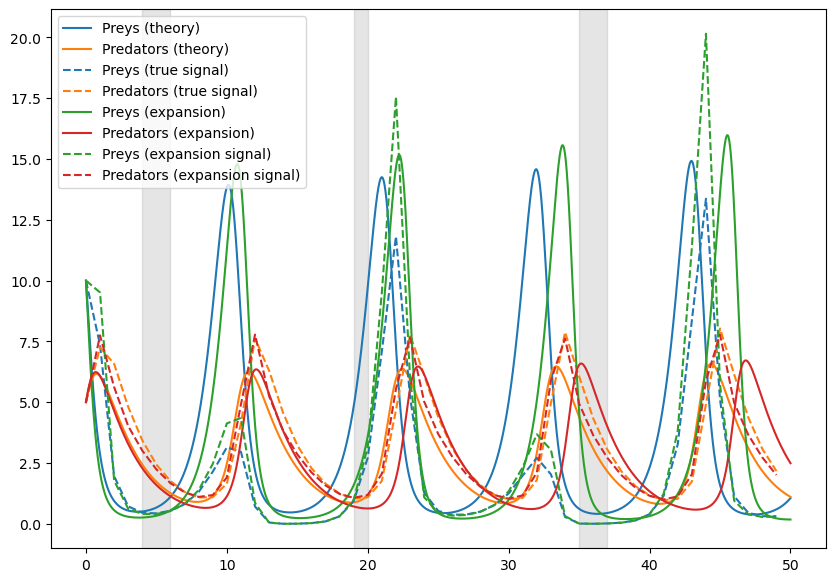

In [8]:
# Plot the expansion function
plt.figure(figsize=(10,7))
plt.plot(t,Xtheory,label="Preys (theory)")
plt.plot(t,Ytheory,label="Predators (theory)")
plt.plot(np.arange(tmax),Xtsignal,ls="--",color="C0",label="Preys (true signal)")
plt.plot(np.arange(tmax),Ytsignal,ls="--",color="C1",label="Predators (true signal)")
plt.plot(t,Xthexp,label="Preys (expansion)")
plt.plot(t,Ythexp,label="Predators (expansion)")
plt.plot(np.arange(tmax),Xssignal,ls="--",color="C2",label="Preys (expansion signal)")
plt.plot(np.arange(tmax),Yssignal,ls="--",color="C3",label="Predators (expansion signal)")
ymin, ymax = plt.ylim()
for i in range(len(masks)):
    plt.fill_between(masks[i],np.ones_like(masks[i])*ymin,np.ones_like(masks[i])*ymax,color="C7",alpha=0.2)
plt.ylim(ymin,ymax)
plt.legend(loc="best")
plt.show()

## Simulations at the expansion point

In [9]:
# Run a batch of simulations
sims0 = []
sims1 = []

Nsims=200
for sim in range(Nsims):
    LVs.observe(model=0, tmax=tmax, Xefficiency=Xefficiency0, Yefficiency=Yefficiency0, threshold=threshold, mask=mask, obsP=obsP, obsQ=obsQ, obsR=obsR0, obsS=obsS, obsT=obsT)
    Xobs, Xsim0, Yobs, Ysim0 = LVs.Xobs, LVs.Xdata, LVs.Yobs, LVs.Ydata
    sims0.append(np.concatenate([Xsim0,Ysim0]))

    LVs.observe(model=1, tmax=tmax, mask=mask, obsR=0.04)
    Xobs, Xsim1, Yobs, Ysim1 = LVs.Xobs, LVs.Xdata, LVs.Yobs, LVs.Ydata
    sims1.append(np.concatenate([Xsim1,Ysim1]))

sims0=np.array(sims0)
sims1=np.array(sims1)

Xsims0_mean=np.mean(sims0,axis=0)[0:len(Xobs)]
Xsims0_std=np.std(sims0,axis=0)[0:len(Xobs)]
Ysims0_mean=np.mean(sims0,axis=0)[len(Xobs):len(Xobs)+len(Yobs)]
Ysims0_std=np.std(sims0,axis=0)[len(Xobs):len(Xobs)+len(Yobs)]
Xsims1_mean=np.mean(sims1,axis=0)[0:len(Xobs)]
Xsims1_std=np.std(sims1,axis=0)[0:len(Xobs)]
Ysims1_mean=np.mean(sims1,axis=0)[len(Xobs):len(Xobs)+len(Yobs)]
Ysims1_std=np.std(sims1,axis=0)[len(Xobs):len(Xobs)+len(Yobs)]

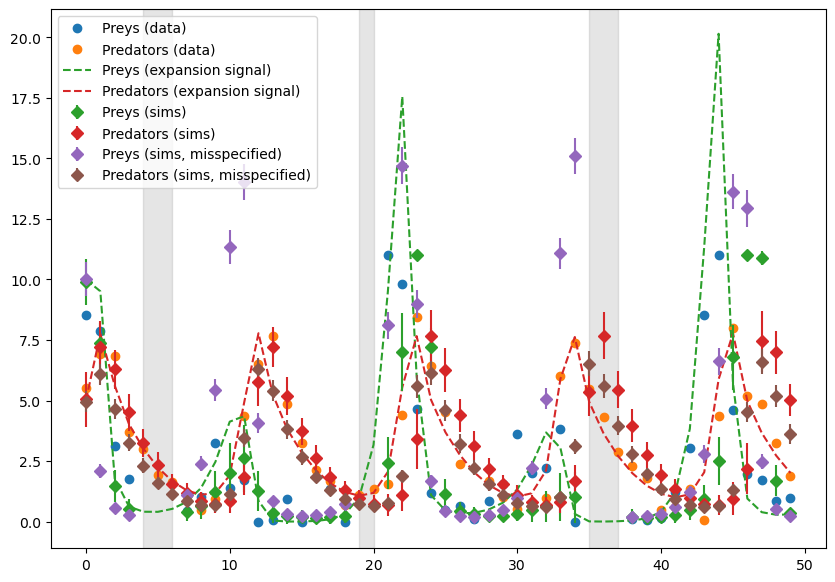

In [10]:
# Plot simulations using correct and misspecified data models
plt.figure(figsize=(10,7))
plt.plot(Xobs,Xdata,marker="o",ls="",color="C0",label="Preys (data)")
plt.plot(Yobs,Ydata,marker="o",ls="",color="C1",label="Predators (data)")
plt.plot(np.arange(tmax),Xssignal,ls="--",color="C2",label="Preys (expansion signal)")
plt.plot(np.arange(tmax),Yssignal,ls="--",color="C3",label="Predators (expansion signal)")
plt.errorbar(Xobs,Xsims0_mean,Xsims0_std,marker="D",ls="",color="C2",label="Preys (sims)")
plt.errorbar(Yobs,Ysims0_mean,Ysims0_std,marker="D",ls="",color="C3",label="Predators (sims)")
plt.errorbar(Xobs,Xsims1_mean,Xsims1_std,marker="D",ls="",color="C4",label="Preys (sims, misspecified)")
plt.errorbar(Yobs,Ysims1_mean,Ysims1_std,marker="D",ls="",color="C5",label="Predators (sims, misspecified)")
ymin, ymax = plt.ylim()
for i in range(len(masks)):
    plt.fill_between(masks[i],np.ones_like(masks[i])*ymin,np.ones_like(masks[i])*ymax,color="C7",alpha=0.2)
plt.ylim(ymin,ymax)
plt.legend(loc="best")
plt.show()

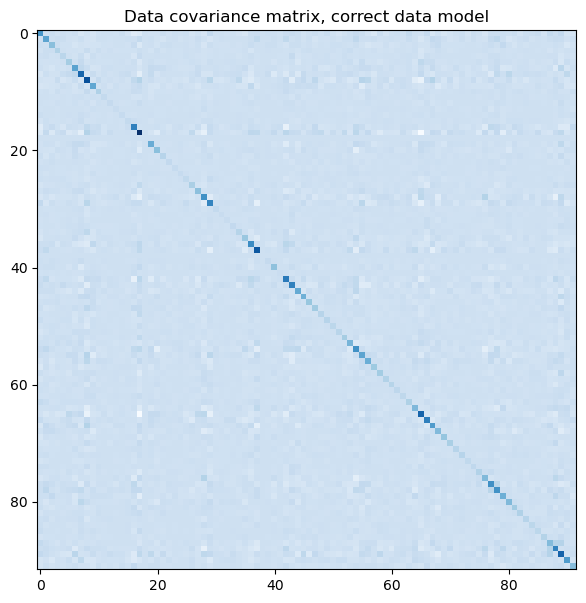

In [11]:
plt.figure(figsize=(7,7))
plt.imshow(np.log(1+np.cov(sims0.T)),cmap="Blues")
plt.title("Data covariance matrix, correct data model")
plt.show()

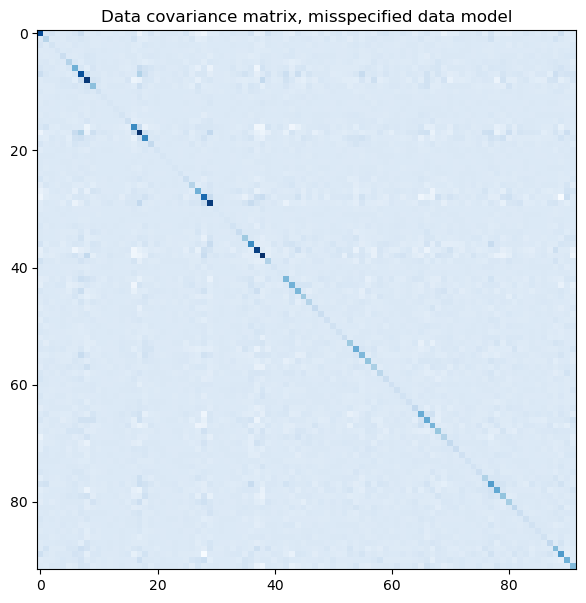

In [12]:
plt.figure(figsize=(7,7))
plt.imshow(np.log(1+np.cov(sims1.T)),cmap="Blues")
plt.title("Data covariance matrix, misspecified data model")
plt.show()

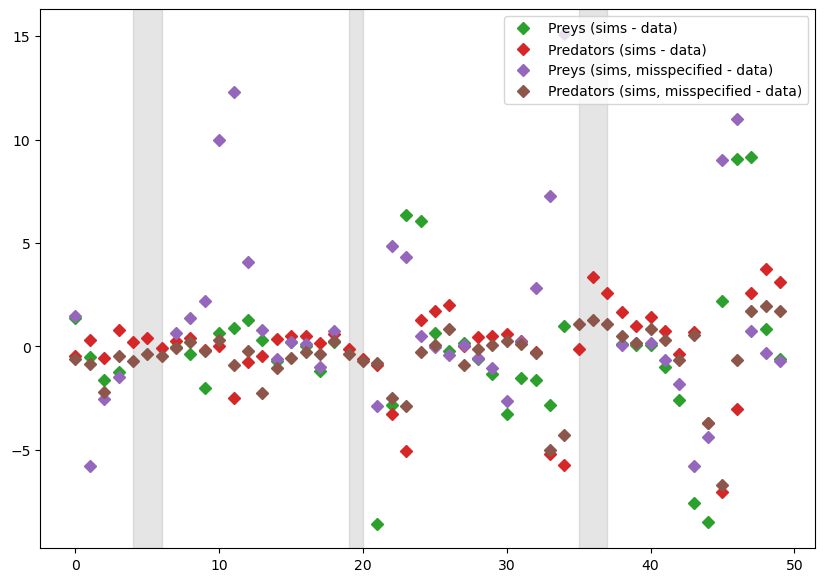

In [13]:
# Plot residuals
plt.figure(figsize=(10,7))
plt.plot(Xobs,Xsims0_mean-Xdata,marker="D",ls="",color="C2",label="Preys (sims - data)")
plt.plot(Yobs,Ysims0_mean-Ydata,marker="D",ls="",color="C3",label="Predators (sims - data)")
plt.plot(Xobs,Xsims1_mean-Xdata,marker="D",ls="",color="C4",label="Preys (sims, misspecified - data)")
plt.plot(Yobs,Ysims1_mean-Ydata,marker="D",ls="",color="C5",label="Predators (sims, misspecified - data)")
ymin, ymax = plt.ylim()
for i in range(len(masks)):
    plt.fill_between(masks[i],np.ones_like(masks[i])*ymin,np.ones_like(masks[i])*ymax,color="C7",alpha=0.2)
plt.ylim(ymin,ymax)
plt.legend(loc="best")
plt.show()